# Preliminary Tutuila Groundwater Optimization 
### Chris Shuler CEE 696 Final Project


### Background

Throughout the 20th century groundwater management has progressed from being an unknown term to becoming a highly prioritized function of any society dependent on this resource. This results from a dramatic global increase in the ratio of groundwater usage to groundwater availability. Tutuila Island in American Samoa is no exception to this trend, and being almost completely dependent on groundwater resources, faces very real consequences for overexploitation of its limited water supplies. Though the concept of sustainable groundwater yield has been discussed for over 100 years, there remains no universal formulae for its calculation, and thus its determination must be qualified by subjective assessments of the acceptability of consequences resulting from a given extraction rate. A common practice for assessing consequences of different extraction rates, is to develop numerical groundwater models of aquifers to simulate pumping effects on parameters of interest, such as water table drawdown, streamflow reduction, or other changes in groundwater behavior. On Tutuila, drinking water aquifers are generally thin freshwater lenses that float above saltwater saturated zones. Significantduction of groundwater head can quickly cause salinization even before much of the freshwater volume is depleted. Sustainable yield estimates are imperative for informing best-management practices for the sustainable use of limited water resources.

#### Objective
This project  investigates methodology for application of pump rate optimization for potential sustainable yield criteria as applied to  pumping wells on the island of Tutuila, American Samoa.

#### Methodologies are detailed in cells below

#### This cell imports necessary python packages for the model

In [63]:
%matplotlib notebook
import scipy.optimize as opt
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt


# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))

#### Pre-processing of geographic data
GMS software was used for pre-processing of geographic inputs in vector and raster format from various sources including: 
- Land-surface elevations from a 10m grid size NOAA DEM
- Recharge rates obtaind from a previous study conducted by ASPA and downsampled
- Well pump rates and locations as provided by ASPA

Additionally, other required parameters were estimatted for the purpose of simplicity and because few reliable datasets exist to parameterize these values. These parameters included, Hydraulic conductivity values of 5 m/day throughout the model domain, model bottom elevations of -600 m throughout the model domain, and a single pumping rate for all wells which was then applied as an optomization paramter. 


## This cell imports model geometry files generated in GMS and defines the model name

In [74]:
# Assign name and create modflow model object
txtname = 'test_no_5'
model_name = flopy.modflow.Modflow(txtname, exe_name='mf2005')

dis = flopy.modflow.ModflowDis.load('TutCoast_simple5.dis', model_name)       # this command is neededed to load an existing .dis file   (essentially is grid geometry)
bas = flopy.modflow.ModflowBas.load('TutCoast_simple5.ba6',model_name)        # add an existing .basic package                         (essentially is ibound and starting heads)
lpf = flopy.modflow.ModflowLpf.load('TutCoast_simple5.lpf', model_name)       # add an existing .lpf file     (hydraulic conductivity)
rch = flopy.modflow.ModflowRch.load('TutCoast_simple5.rch', model_name)       # addd the Recharge package
wel = flopy.modflow.ModflowWel.load('TutCoast_simple5.wel', model_name)       # addd the well package
hobs = flopy.modflow.ModflowHob.load('TutCoast_simple5.hob', model_name)      # addd the obervations well package
pcg = flopy.modflow.ModflowPcg(model_name)                                    # gradient solver package from flopy


# Active model domain in white

<IPython.core.display.Javascript object>


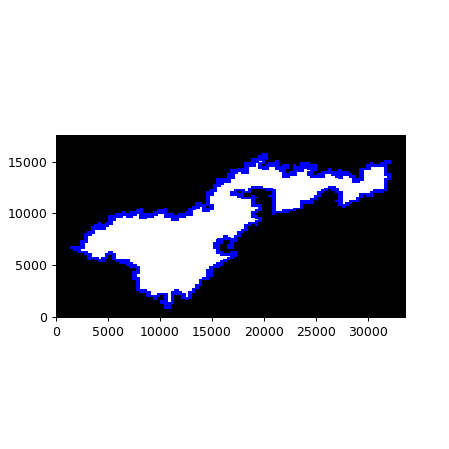

In [75]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap= flopy.plot.ModelMap(model=model_name, layer=0)
qm = modelmap.plot_ibound()

# Recharge added to the model in m$^{3}$/ day

<IPython.core.display.Javascript object>


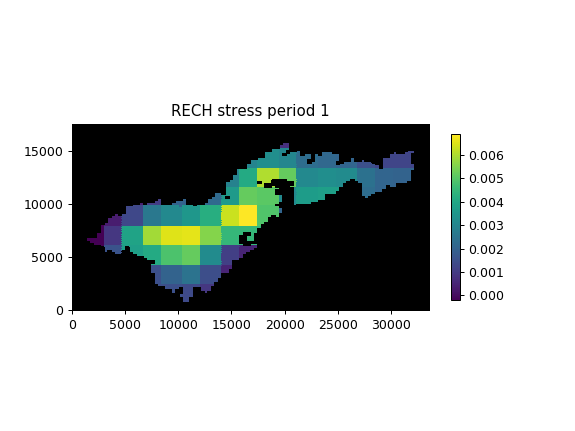

In [76]:
rch.plot()

# The geometric discritization of the model including top and bottom elevations.

<IPython.core.display.Javascript object>


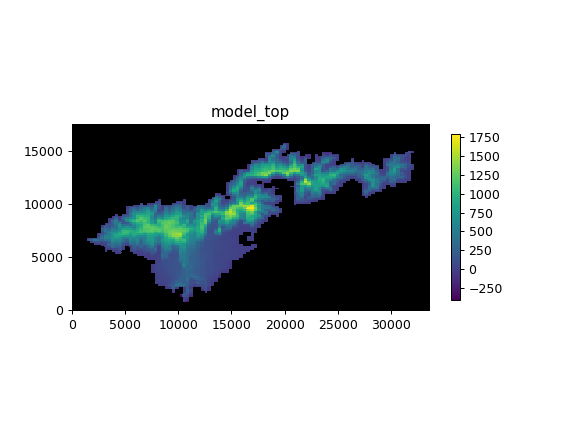

<IPython.core.display.Javascript object>


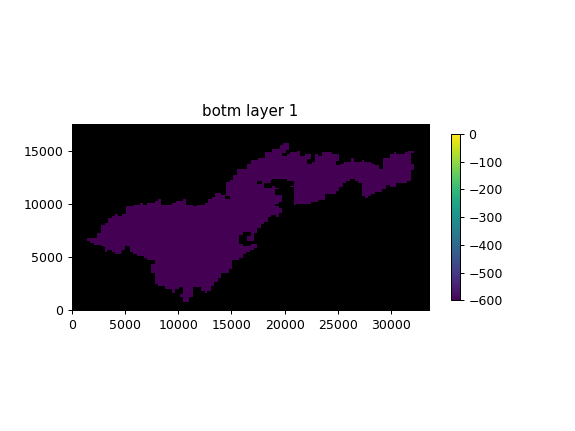

<IPython.core.display.Javascript object>


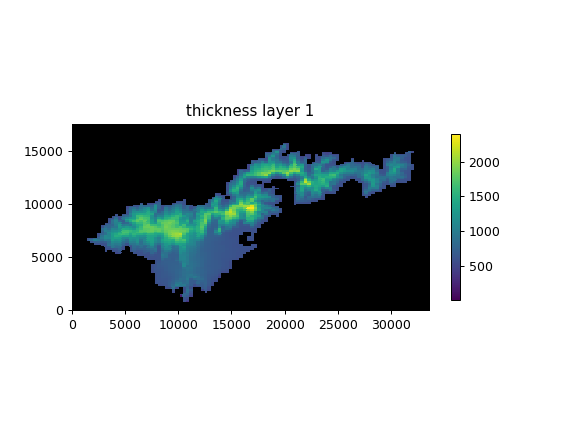

In [77]:
dis.plot()

# The locations of pumping wells, also note that observation points were selected based on near proximity t each pumping well

<IPython.core.display.Javascript object>


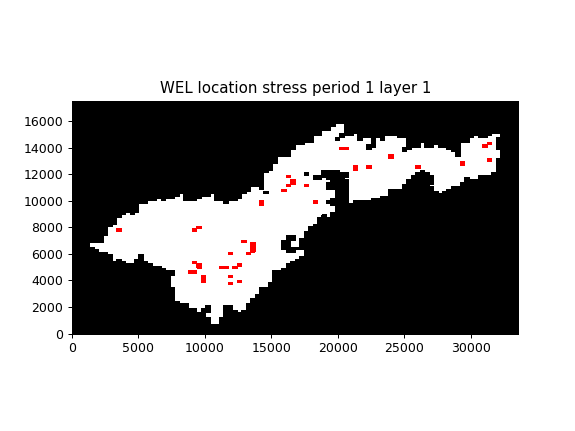

In [78]:
wel.plot()

### Add oupput control variables and write model input files

In [79]:
# Add OC package to the MODFLOW model
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model_name, stress_period_data=spd, compact=True)

# Write the MODFLOW model input files
model_name.write_input()

# Finally run the model and display the head distribution 

FloPy is using the following executable to run the model: mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: test_no_5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/26 22:45:23

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/04/26 22:45:23
 Elapsed run time:  0.039 Seconds

  Normal termination of simulation


<IPython.core.display.Javascript object>


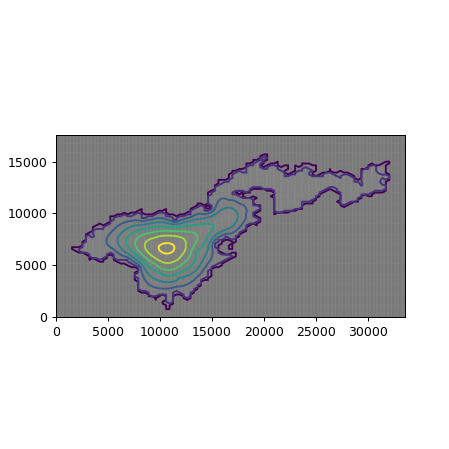

In [81]:
# Run the MODFLOW model
success, buff = model_name.run_model()

# Post process the results

hds = bf.HeadFile(txtname + '.hds')
head = hds.get_data(totim=1.0)
levels = np.linspace(0, 10, 11)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

hds = bf.HeadFile(txtname+'.hds')
times = hds.get_times()
head = hds.get_data(totim=times[-1])
levels = np.linspace(0, 10, 11)

cbb = bf.CellBudgetFile(txtname+'.cbc')
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.ModelMap(model=model_name, layer=0)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
cs = modelmap.contour_array(head, levels=levels)
quiver = modelmap.plot_discharge(frf, fff, head=head)

# In order to optomize the model parameters the model is "wrapped" into a python Class, with specific & callable functions 

In [82]:
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt


class Fin_Mod:
    """
    modflow model for multiple well pumping
    every values are represented as 2D np array
    """
    def __init__(self):


        # Assign name and create modflow model object
        txtname = 'test_no_5.2'
        self.model_name = flopy.modflow.Modflow(txtname, exe_name='mf2005')
        self.txtname = txtname

        dis = flopy.modflow.ModflowDis.load('TutCoast_simple5.dis', self.model_name)       # this command is neededed to load an existing .dis file   (essentially is grid geometry)
        bas = flopy.modflow.ModflowBas.load('TutCoast_simple5.ba6',self.model_name)        #  load an existing .basic package                         (essentially is ibound and starting heads)
        lpf = flopy.modflow.ModflowLpf.load('TutCoast_simple5.lpf', self.model_name)       #  load an existing .lpf file    
        rch = flopy.modflow.ModflowRch.load('TutCoast_simple5.rch', self.model_name)       # load recharge
        hobs = flopy.modflow.ModflowHob.load('TutCoast_simple5.hob', self.model_name)      #  LOad OBS
        

        # Add PCG package to the MODFLOW model
        pcg = flopy.modflow.ModflowPcg(self.model_name)
        
        # Add OC package to the MODFLOW model
        spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
        oc = flopy.modflow.ModflowOc(self.model_name, stress_period_data=spd, compact=True)
  
     

    def run(self, All_Qs):
        
        # yay here is where we can mess with the well pump rates (this changes all of them at once)
        wel = flopy.modflow.ModflowWel.load('TutCoast_simple5.wel', self.model_name)
                  
        for idx, i in enumerate(wel.stress_period_data[1]):
            wel.stress_period_data[1][idx][3] = All_Qs 
            
                # MODFLOW input
        # Write the MODFLOW model input files
        # If we cannot (over)write input files, try to write until it succeeds
        while True:
            try:
                self.model_name.write_input()
            except OSError as err:
                print("File writing error: %s" % (err))
            else:  # if we succeed, get out of the loop
                break

        # Run the MODFLOW model
        success, buff = self.model_name.run_model(silent=True)

        return success

    
    def head(self):
        """
            minimum head value
        """

        hds = bf.HeadFile(self.txtname + '.hds')
        times = hds.get_times()  # simulation time, steady state
        heads = hds.get_data(totim=times[-1])
        hds.close()  # close the file object for the next run

        return heads
    
    
    def minhead(self):
        """
            minimum head value
        """

        return self.head().min()
    
    
    def plot(self,title="head"):
        fig = plt.figure(figsize=(9, 5))
        ax = fig.add_subplot(1, 1, 1, aspect='equal')

        modelmap = flopy.plot.ModelMap(model=self.model_name, layer=0) # broken fix somehow
        qm = modelmap.plot_ibound()
        lc = modelmap.plot_grid()

        levels = np.linspace(0, self.head().max(), 11)
        cs = modelmap.contour_array(self.head(), levels=levels)
        fig.colorbar(cs)
        plt.title(title)
        plt.show()
        return # return nothing, but function should end with return
    
    def uniquehead(self):
        return np.unique(self.head())
    

# Now the model is able to be run with one command and inputs and outputs can be itterativly looped over to find an optomized model solution 

pumpting rate: -1000.000000, penalty : 0.000000, objective value: -62000.000000
pumpting rate: -1050.000000, penalty : 0.000000, objective value: -65100.000000
pumpting rate: -1100.000000, penalty : 0.000000, objective value: -68200.000000
pumpting rate: -1150.000000, penalty : 0.000000, objective value: -71300.000000
pumpting rate: -1250.000000, penalty : 0.000000, objective value: -77500.000000
pumpting rate: -1350.000000, penalty : 0.000000, objective value: -83700.000000
pumpting rate: -1550.000000, penalty : 0.000000, objective value: -96100.000000
pumpting rate: -1750.000000, penalty : 0.000000, objective value: -108500.000000
pumpting rate: -2150.000000, penalty : 27826883.644132, objective value: 27693583.644132
pumpting rate: -1550.000000, penalty : 0.000000, objective value: -96100.000000
pumpting rate: -1950.000000, penalty : 0.000000, objective value: -120900.000000
pumpting rate: -2150.000000, penalty : 27826883.644132, objective value: 27693583.644132
pumpting rate: -2150

<IPython.core.display.Javascript object>


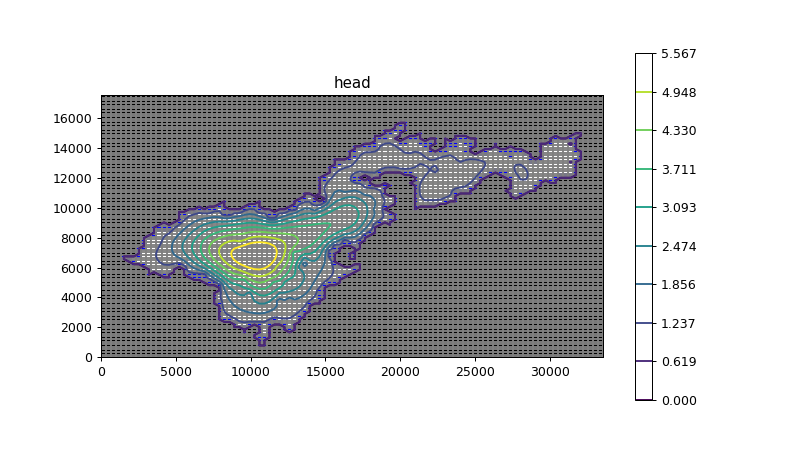

Water obtained is  -2091.390800476074 cubic m per day, with max drawdown of  3 m


In [86]:
def optomizo(Q):                   # optomizer function 
    model = Fin_Mod()              # the model 
    model.run(Q)                   # run the model

    objval = Q                     

    observations = np.loadtxt('test_no_5.2.hob.out', skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
    residuals= []
    for idx, i in enumerate(observations):   
        r = observations[idx][1]-observations[idx][0]
        residuals.append(r)
    top_draw = max(residuals)
    
    rates = np.loadtxt('test_no_5.2.wel', skiprows=3, usecols=3)                     # this block sums all of the pump rates to get a grand total of pumping throughout all 62 wells
    Sum_Q = sum(rates)

    if top_draw > 3:                                                         # this is where the maximum allwable drawdown is defined
        penalty = 100000* (top_draw + 1.0) ** 4                              # this is where the penalty (i.e. a large number) for exceeding maximum allwable drawdown is defined        
    else: 
        penalty = 0

    cost_ben = Sum_Q + penalty                                               # objective value to be minimized, basically what you get in water minus the cost of exceeding the drawdown requirements                                     
    print("pumpting rate: %f, penalty : %f, objective value: %f" % (Q, penalty, cost_ben)) 
    return cost_ben

# Use Nelder-Mead/Simplex method for this problem
results = opt.minimize(optomizo, x0=-1000.,method="Nelder-Mead",tol = 0.01)

Good_Q = float(results['final_simplex'][0][0])                               # the optomal pumping rate
Fin_Mod().run(Good_Q)                                                        # run and plot the model at the optomal pumping rate
Fin_Mod().plot()

print("Water obtained is  {} cubic m per day, with max drawdown of  3 m".format(Good_Q, ))

In [87]:
results           # optomization run statistics

 final_simplex: (array([[-2091.39080048],
       [-2091.39084816]]), array([-129666.2358, -129666.2358]))
           fun: -129666.23579999992
       message: 'Optimization terminated successfully.'
          nfev: 85
           nit: 42
        status: 0
       success: True
             x: array([-2091.39080048])